<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 32kB/s 


In [2]:
pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [3]:
import tensorflow
import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from keras.metrics import BinaryAccuracy
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from keras import optimizers


import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'

Using TensorFlow backend.


In [5]:
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
print('enter the environment directory')
directory = input()
COLAB_DIR = join(HOME, directory)
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
enter the environment directory
temp


In [0]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')

In [7]:
labels = pandas.DataFrame()
labels['CLASS'] = numpy.where(data['CLOSE'] > data['CLOSE'].shift(1), 1.0, 0.0)
labels['DATE'] = data['DATE'].copy()
labels['TICKER'] = data['TICKER'].copy()
labels.head(10)

,CLASS,DATE,TICKER
0,0.0,2019-11-20,مظنه
1,0.0,2019-11-23,مظنه
2,0.0,2019-11-24,مظنه
3,0.0,2019-11-25,مظنه
4,0.0,2019-11-26,مظنه
5,0.0,2019-11-27,مظنه
6,0.0,2019-11-30,مظنه
7,0.0,2019-12-01,مظنه
8,0.0,2019-12-02,مظنه
9,0.0,2019-12-03,مظنه


Let's assert if we are using GPU.

In [8]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## **Visualization Task**

**Let's do some visualizations first to investigate data set we are working with**

In [9]:
mean_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.mean).reset_index().sort_values('VOL', ascending=False)
mean_vol_per_ticker.head()

,TICKER,VOL
894,شاخص_قيمت(هم_وزن6),1.560700e+09
895,شاخص_قيمت6,1.559693e+09
898,شاخص_كل_(هم_وزن)6,1.559693e+09
889,شاخص_آزاد_شناور6,9.130124e+08
897,شاخص_كل6,8.711138e+08


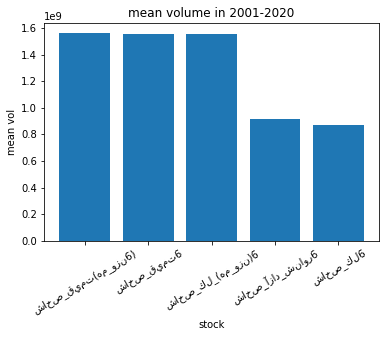

In [10]:
 five_first_stocks_with_mean_vol = mean_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_mean_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_mean_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('mean vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_mean_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('mean volume in 2001-2020')
 plt.show()

In [11]:
data_for_ticker_with_max_mean_vol = data[ data['TICKER'] == mean_vol_per_ticker.head().iloc[0]['TICKER'] ]
data_for_ticker_with_max_mean_vol.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
3004878,شاخص_قيمت(هم_وزن6),2015-02-24,9198.4,9181.8,9181.8,9181.8,278521094
3004879,شاخص_قيمت(هم_وزن6),2015-02-25,9183.3,9109.1,9109.2,9109.1,271188153
3004880,شاخص_قيمت(هم_وزن6),2015-02-28,9111.9,9090.0,9090.0,9090.0,257849083
3004881,شاخص_قيمت(هم_وزن6),2015-03-01,9014.4,9030.4,9009.0,9030.4,475683577
3004882,شاخص_قيمت(هم_وزن6),2015-03-02,9034.4,9043.5,9034.4,9043.5,717632564


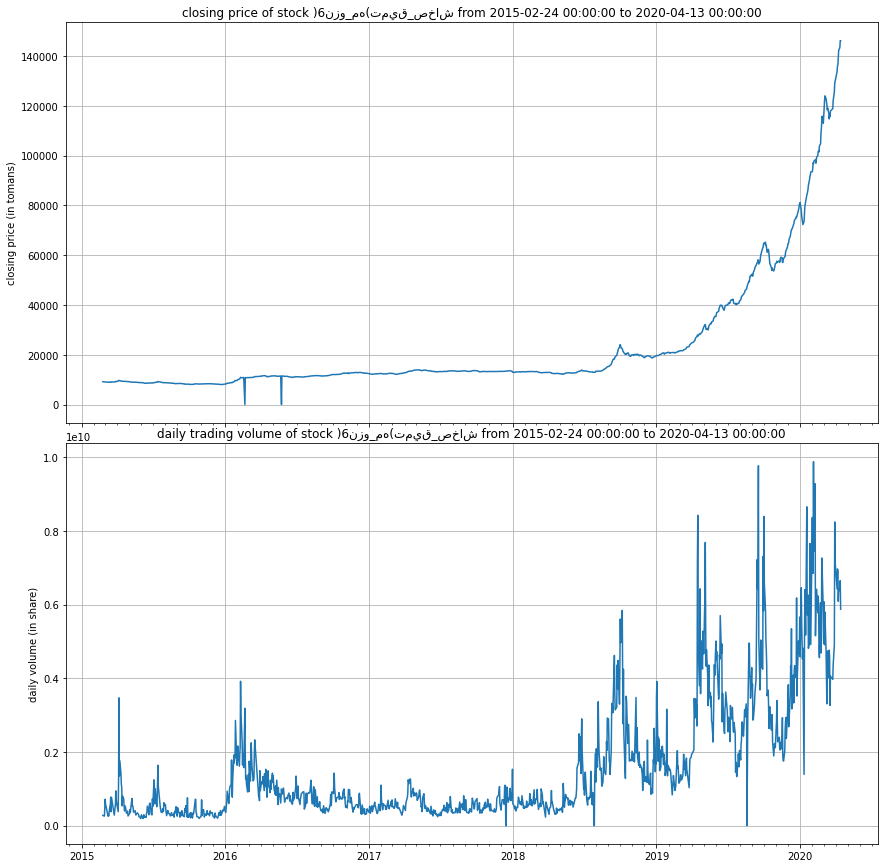

In [12]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,12))
fig.tight_layout()

ax1 = axs[0]
ax2 = axs[1]
starting_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[0])
ending_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[len(data_for_ticker_with_max_mean_vol) - 1])

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)


ax1.plot(data_for_ticker_with_max_mean_vol['DATE'], data_for_ticker_with_max_mean_vol['CLOSE'])
ax1.set(ylabel='closing price (in tomans)')
ax1.set_title('closing price of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date + ' to ' + ending_date)
ax2.plot(data_for_ticker_with_max_mean_vol['DATE'], data_for_ticker_with_max_mean_vol['VOL'])
ax2.set(ylabel='daily volume (in share)')
ax2.set_title('daily trading volume of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date + ' to ' + ending_date)

ax1.grid(True)
ax2.grid(True)

ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax1.format_ydata = lambda x: '$%1.2f' % x  # format the price.

plt.show()

In [13]:
ten_stocks_with_max_trading_days = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[0]
ten_stocks_with_max_trading_days.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

## **Stateful LSTM**

**Now it is time to start training our model**

We use adam optimizer throughout this experiment.

In [0]:
from numpy.random import uniform

window_in_days = 10

class MyNormalizer:
  def __init__(self):
    self.max = 0
    self.min = 0

  def fit(self, data):
    self.max = data.max()
    self.min = data.min()
  
  def transform(self, data):
    return (data - self.min) / (self.max - self.min)


def align_data(x, y, window_in_days, batch_size):
  rows_to_insert_to_x = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size),len(x.columns))), columns=x.columns)
  rows_to_insert_to_y = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size), len(y.columns))), columns=y.columns)

  return pandas.concat([rows_to_insert_to_x, x], ignore_index=True), pandas.concat([rows_to_insert_to_y, y], ignore_index=True)
  

def split_data_to_train_test(original_dataset, labels, stock, training_start, training_end, testing_start, testing_end, test_required=True):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ].drop('TICKER', axis=1)
  labels_related_to_stock = labels[ labels['TICKER'] == stock ].drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) & (data_related_to_stock['DATE'] <= training_end ) 
  training_period = data_related_to_stock.loc[training_period_mask].drop('DATE', axis=1)
  training_period_labels = labels_related_to_stock.loc[training_period_mask].drop('DATE', axis=1)

  testing_period = None
  testing_period_labels = None
  if test_required:
    testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) & (data_related_to_stock['DATE'] <= testing_end )
    testing_period = data_related_to_stock.loc[testing_period_mask].drop('DATE', axis=1)
    testing_period_labels = labels_related_to_stock.loc[testing_period_mask].drop('DATE', axis=1)

  return training_period, training_period_labels , testing_period, testing_period_labels


def normalize_dataframe_with_max_min(dataframe, train_max, train_min):
    normalized_df=(dataframe - train_min)/(train_max - train_min)
    return normalized_df


def generate_datasets_for_model(original_dataset, labels, stock, training_start, training_end, \
                                testing_start, testing_end, window_in_days=10, batch_size=32, test_required=True):
  normalizer = MyNormalizer()
  training_data = []
  training_labels = []
  testing_data = []
  testing_labels = []

  training_period, training_period_labels, testing_period, testing_period_labels = split_data_to_train_test(original_dataset, labels, stock, training_start, training_end \
                                                                                                            , testing_start, testing_end, test_required)

  training_period, training_period_labels = align_data(training_period, training_period_labels, window_in_days, batch_size)

  if test_required:
    testing_period, testing_period_labels = align_data(testing_period, testing_period_labels, window_in_days, batch_size)                                                                                               

  normalizer.fit(training_period)
  training_period = normalizer.transform(training_period)

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(numpy.array(training_period_labels.iloc[j]))

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)

  if test_required:
    testing_period = normalizer.transform(testing_period)
    for j in range(window_in_days, len(testing_period)):
      testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
      testing_labels.append(numpy.array(testing_period_labels.iloc[j]))

  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)

  train_generator = DataGenerator(training_data, training_labels, batch_size=batch_size)
  test_generator = DataGenerator(testing_data, testing_labels, batch_size=batch_size)

  return train_generator, test_generator



In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, batch_size=32):
        'Initialization'
        self.data = data
        self.dim = data.shape
        self.batch_size = batch_size
        self.labels = labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(numpy.floor(self.dim[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        x = self.data[index * self.batch_size: (index + 1) * self.batch_size]

        y = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
        
        return x, y

    def on_epoch_end(self):
        pass

In [0]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

In [0]:

def build_model(input_shape, optimizer='adam', layers=None, loss='binary_crossentropy', metrics=[BinaryAccuracy(name='accuracy')]):
  if layers is None:
    model = Sequential()
    model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dense(4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

  else:
    model = Sequential(layers)
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)


  return model


In [0]:
from keras.callbacks import ProgbarLogger
from datetime import datetime

class MyLogger(ProgbarLogger):
    def __init__(self, verbose, count_mode='samples'):
        # Ignore the `verbose` argument specified in `fit()` and pass `count_mode` upstream
        self.verbose = verbose
        self.metrics = ['loss', 'accuracy']
        self.epoch_start = 0
        self.epoch_finish = 0
        # print(self.params)

    def on_train_begin(self, logs=None):
        pass
        # filter out the training metrics

    def on_epoch_begin(self, epoch, logs=None):
        self.params['metrics'] = self.metrics
        self.epochs = self.params['epochs']
        if self.verbose:
            print('----------->> Epoch %d/%d' % (epoch + 1, self.epochs), end='   ')
        self.epoch_start = datetime.now()

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_finish = datetime.now()
        duration = (self.epoch_finish - self.epoch_start).total_seconds()
        print('%.3f seconds' % (duration), end=' , ')
        self.log_values = []
        logs = logs or {}
        for k in self.params['metrics']:
            if k in logs:
                self.log_values.append((k, logs[k]))
        if self.verbose:
            for metric, value in self.log_values:
              print('%s : %.3f' % ( metric, value), end='    ')
        print()
    
    def on_train_end(self, logs=None):
        pass


In [0]:
# results is in form of [loss, acc, true positives, false positives, true negatives, false negatives]
def calc_pos_neg_rate(results):
  new_results = {}
  new_results['loss'] = results[0] # loss
  new_results['acc'] = results[1] # accuracy
  new_results['true_positive_rate'] = (results[2]) / (results[2] + results[5]) # true positive rate
  new_results['false_positive_rate'] = (results[3]) / (results[3] + results[4]) # false positive rate
  new_results['positive_precision'] = (results[2]) / (results[2] + results[3]) # positive precision
  new_results['negative_precision'] = (results[4]) / (results[4] + results[5]) # negative precision
  return new_results

Now, we want to train the model using different window sizes to see the effect on the performance of the model. Throughout the document, we also report true positive rate, false positive rate, positive precision and negative precision.

Let's start with window size of 10.

In [0]:
optimizer = optimizers.Adam(learning_rate=0.001)

In [0]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_21 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_6 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_22 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_6 (Batch (32, 16)                  64        
_________________________________________________________________
dense_23 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_24 (Dense)             (32, 1)                  

In [0]:
epochs = 200


def fit(model, epochs, train_generator):
  train_losses = []

  train_accs = []

  for i in range(epochs):
      print('epoch %d' % (i + 1))
      history = model.fit(x=train_generator,
                        epochs=1,
                        verbose=0,
                        callbacks=[MyLogger(1)]
                        )
      train_accs.append(history.history['accuracy'])
      train_losses.append(history.history['loss'])
      model.reset_states() 
  return train_accs, train_losses

In [0]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   2.124 seconds , loss : 0.687    accuracy : 0.586    
epoch 2
----------->> Epoch 1/1   1.724 seconds , loss : 0.671    accuracy : 0.611    
epoch 3
----------->> Epoch 1/1   1.702 seconds , loss : 0.666    accuracy : 0.614    
epoch 4
----------->> Epoch 1/1   1.646 seconds , loss : 0.665    accuracy : 0.615    
epoch 5
----------->> Epoch 1/1   1.675 seconds , loss : 0.661    accuracy : 0.612    
epoch 6
----------->> Epoch 1/1   1.643 seconds , loss : 0.660    accuracy : 0.616    
epoch 7
----------->> Epoch 1/1   1.668 seconds , loss : 0.658    accuracy : 0.619    
epoch 8
----------->> Epoch 1/1   1.720 seconds , loss : 0.656    accuracy : 0.619    
epoch 9
----------->> Epoch 1/1   1.631 seconds , loss : 0.657    accuracy : 0.619    
epoch 10
----------->> Epoch 1/1   1.681 seconds , loss : 0.653    accuracy : 0.631    
epoch 11
----------->> Epoch 1/1   1.703 seconds , loss : 0.657    accuracy : 0.624    
epoch 12
----------->> Epoch 1/1   1.652 

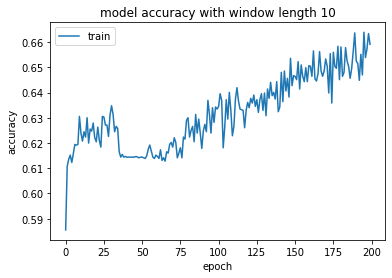

In [0]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

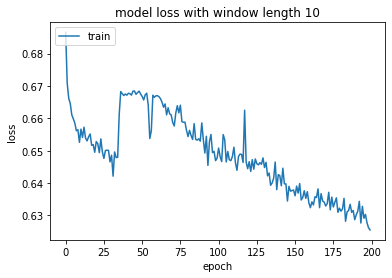

In [0]:
plt.plot(train_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
model.reset_states()
results = calc_pos_neg_rate(model.evaluate(x=test_generator))
print('test:', results)

5/5 [==============================] - 0s 6ms/step
test: {'loss': 0.9178492426872253, 'acc': 0.4437499940395355, 'true_positive_rate': 0.038461538461538464, 'false_positive_rate': 0.3611111111111111, 'positive_precision': 0.04878048780487805, 'negative_precision': 0.5798319327731093}


In [0]:
model.reset_states()
results = calc_pos_neg_rate(model.evaluate(x=train_generator))
print('train:', results)

118/118 [==============================] - 1s 5ms/step
train: {'loss': 0.09690910577774048, 'acc': 0.6006355881690979, 'true_positive_rate': 0.1565934065934066, 'false_positive_rate': 0.1206896551724138, 'positive_precision': 0.44881889763779526, 'negative_precision': 0.6242350061199511}


Now, let's try window size of 20

In [0]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=20)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_37 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_10 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_38 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_10 (Batc (32, 16)                  64        
_________________________________________________________________
dense_39 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_40 (Dense)             (32, 1)                  

In [0]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   2.973 seconds , loss : 0.696    accuracy : 0.585    
epoch 2
----------->> Epoch 1/1   2.594 seconds , loss : 0.672    accuracy : 0.613    
epoch 3
----------->> Epoch 1/1   2.626 seconds , loss : 0.669    accuracy : 0.612    
epoch 4
----------->> Epoch 1/1   2.547 seconds , loss : 0.668    accuracy : 0.611    
epoch 5
----------->> Epoch 1/1   2.608 seconds , loss : 0.664    accuracy : 0.608    
epoch 6
----------->> Epoch 1/1   2.622 seconds , loss : 0.664    accuracy : 0.615    
epoch 7
----------->> Epoch 1/1   2.638 seconds , loss : 0.662    accuracy : 0.612    
epoch 8
----------->> Epoch 1/1   2.573 seconds , loss : 0.661    accuracy : 0.618    
epoch 9
----------->> Epoch 1/1   2.559 seconds , loss : 0.660    accuracy : 0.616    
epoch 10
----------->> Epoch 1/1   2.593 seconds , loss : 0.661    accuracy : 0.619    
epoch 11
----------->> Epoch 1/1   2.608 seconds , loss : 0.659    accuracy : 0.615    
epoch 12
----------->> Epoch 1/1   2.604 

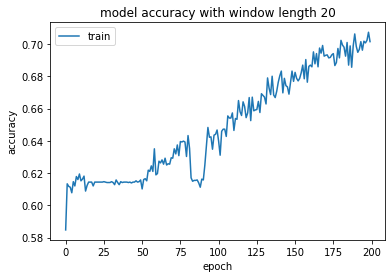

In [0]:
plt.plot(train_accs)
plt.title('model accuracy with window length 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

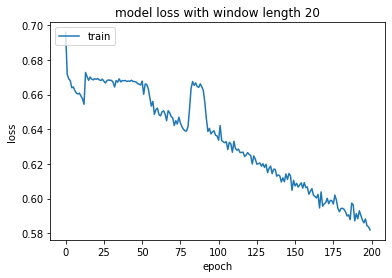

In [0]:
plt.plot(train_losses)
plt.title('model loss with window length 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
model.reset_states()
results = calc_pos_neg_rate(model.evaluate(x=test_generator))
print('test:', results)

5/5 [==============================] - 0s 7ms/step
test: {'loss': 0.6745532751083374, 'acc': 0.40625, 'true_positive_rate': 0.75, 'false_positive_rate': 0.7592592592592593, 'positive_precision': 0.32231404958677684, 'negative_precision': 0.6666666666666666}


In [0]:
model.reset_states()
results = calc_pos_neg_rate(model.evaluate(x=train_generator))
print('train:', results)

118/118 [==============================] - 1s 7ms/step
train: {'loss': 0.5136227607727051, 'acc': 0.5248940587043762, 'true_positive_rate': 0.6243131868131868, 'false_positive_rate': 0.5375, 'positive_precision': 0.42161410018552875, 'negative_precision': 0.6623456790123456}


Now, let's try window size of 30

In [35]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=30)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_9 (Dense)              (32, 32)                  2080      
_________________________________________________________________
dropout_3 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_10 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_3 (Batch (32, 16)                  64        
_________________________________________________________________
dense_11 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_12 (Dense)             (32, 1)                  

In [36]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   3.817 seconds , loss : 0.690    accuracy : 0.584    
epoch 2
----------->> Epoch 1/1   3.443 seconds , loss : 0.667    accuracy : 0.613    
epoch 3
----------->> Epoch 1/1   3.410 seconds , loss : 0.667    accuracy : 0.608    
epoch 4
----------->> Epoch 1/1   3.427 seconds , loss : 0.666    accuracy : 0.615    
epoch 5
----------->> Epoch 1/1   3.376 seconds , loss : 0.661    accuracy : 0.618    
epoch 6
----------->> Epoch 1/1   3.401 seconds , loss : 0.663    accuracy : 0.611    
epoch 7
----------->> Epoch 1/1   3.354 seconds , loss : 0.660    accuracy : 0.615    
epoch 8
----------->> Epoch 1/1   3.358 seconds , loss : 0.656    accuracy : 0.623    
epoch 9
----------->> Epoch 1/1   3.401 seconds , loss : 0.654    accuracy : 0.624    
epoch 10
----------->> Epoch 1/1   3.346 seconds , loss : 0.654    accuracy : 0.625    
epoch 11
----------->> Epoch 1/1   3.361 seconds , loss : 0.653    accuracy : 0.624    
epoch 12
----------->> Epoch 1/1   3.403 

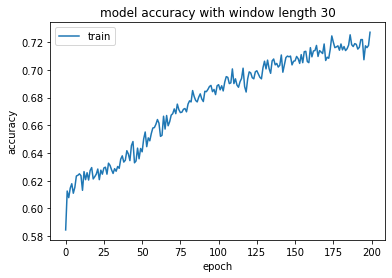

In [37]:
plt.plot(train_accs)
plt.title('model accuracy with window length 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

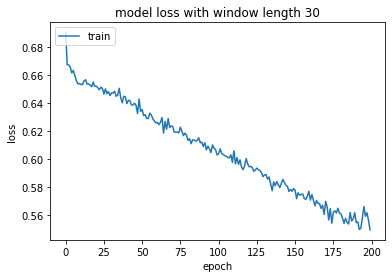

In [38]:
plt.plot(train_losses)
plt.title('model loss with window length 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [39]:
model.reset_states()
results = calc_pos_neg_rate(model.evaluate(x=test_generator))
print('test:', results)

5/5 [==============================] - 0s 31ms/step
test: {'loss': 0.6514817476272583, 'acc': 0.44999998807907104, 'true_positive_rate': 0.5384615384615384, 'false_positive_rate': 0.5925925925925926, 'positive_precision': 0.30434782608695654, 'negative_precision': 0.6470588235294118}


In [40]:
model.reset_states()
results = calc_pos_neg_rate(model.evaluate(x=train_generator))
print('train:', results)

118/118 [==============================] - 1s 8ms/step
train: {'loss': 0.4110163450241089, 'acc': 0.6739936470985413, 'true_positive_rate': 0.4690934065934066, 'false_positive_rate': 0.19741379310344828, 'positive_precision': 0.5985977212971078, 'negative_precision': 0.7066413662239089}


Now, let's train the stateful model for 1000 epochs.

In [0]:
epochs = 1000
train_accs, train_losses = fit(model, epochs, train_generator)

Epoch 1 / 1000
768/768 [==============================] - 0s 223us/step
val_loss: 0.687, train_loss: 0.740, train_binary_accuracy: 0.578,  val_binary_accuracy: 0.618
Epoch 2 / 1000
768/768 [==============================] - 0s 112us/step
val_loss: 0.677, train_loss: 0.685, train_binary_accuracy: 0.579,  val_binary_accuracy: 0.618
Epoch 3 / 1000
768/768 [==============================] - 0s 124us/step
val_loss: 0.683, train_loss: 0.675, train_binary_accuracy: 0.600,  val_binary_accuracy: 0.618
Epoch 4 / 1000
768/768 [==============================] - 0s 123us/step
val_loss: 0.726, train_loss: 0.674, train_binary_accuracy: 0.594,  val_binary_accuracy: 0.596
Epoch 5 / 1000
768/768 [==============================] - 0s 112us/step
val_loss: 0.735, train_loss: 0.674, train_binary_accuracy: 0.592,  val_binary_accuracy: 0.596
Epoch 6 / 1000
768/768 [==============================] - 0s 113us/step
val_loss: 0.741, train_loss: 0.669, train_binary_accuracy: 0.610,  val_binary_accuracy: 0.596
Epoc

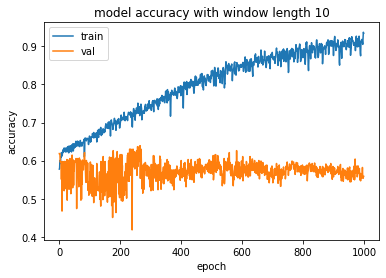

In [0]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 and 1000 epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

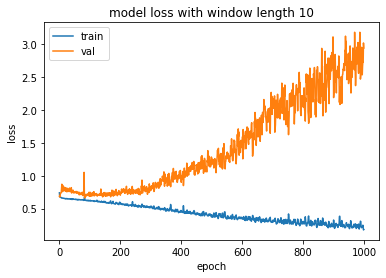

In [0]:
plt.plot(train_losses)
plt.title('model loss with window length 10 and 1000 epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
results = calc_neg_pos_rate(model.evaluate(x=test_generator))
print('test:', results)

160/160 [==============================] - 0s 144us/step
for window length 10 we have: test loss, test acc: [5.467251539230347, 0.40625]


In [0]:
results = calc_neg_pos_rate(model.evaluate(x=train_generator))
print('train:', results)

Next, we train the model for 1200 epochs and save it for further use. This time, we have no validation and we train on the whole dataset.

In [0]:
_training_end = pandas.to_datetime('20200501', format='%Y%m%d', errors='ignore')

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,training_data.shape[1], training_data.shape[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]


train_generator, _ = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, _training_end, None, None, test_required=False)
metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(train_generator.dim, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_41 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_11 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_42 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_11 (Batc (32, 16)                  64        
_________________________________________________________________
dense_43 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_44 (Dense)             (32, 1)                 

In [0]:
epochs = 1200
fit(model, epochs, train_generator)

Epoch 1 / 1200
train_loss: 0.709, train_binary_accuracy: 0.574
Epoch 2 / 1200
train_loss: 0.680, train_binary_accuracy: 0.596
Epoch 3 / 1200
train_loss: 0.678, train_binary_accuracy: 0.599
Epoch 4 / 1200
train_loss: 0.676, train_binary_accuracy: 0.598
Epoch 5 / 1200
train_loss: 0.675, train_binary_accuracy: 0.597
Epoch 6 / 1200
train_loss: 0.673, train_binary_accuracy: 0.604
Epoch 7 / 1200
train_loss: 0.673, train_binary_accuracy: 0.604
Epoch 8 / 1200
train_loss: 0.672, train_binary_accuracy: 0.600
Epoch 9 / 1200
train_loss: 0.671, train_binary_accuracy: 0.607
Epoch 10 / 1200
train_loss: 0.669, train_binary_accuracy: 0.603
Epoch 11 / 1200
train_loss: 0.668, train_binary_accuracy: 0.604
Epoch 12 / 1200
train_loss: 0.669, train_binary_accuracy: 0.604
Epoch 13 / 1200
train_loss: 0.667, train_binary_accuracy: 0.603
Epoch 14 / 1200
train_loss: 0.667, train_binary_accuracy: 0.604
Epoch 15 / 1200
train_loss: 0.663, train_binary_accuracy: 0.607
Epoch 16 / 1200
train_loss: 0.666, train_binary_a

([[0.5739051],
  [0.5964872],
  [0.59945256],
  [0.59785587],
  [0.59694344],
  [0.60378647],
  [0.6035584],
  [0.59990877],
  [0.6069799],
  [0.6028741],
  [0.60378647],
  [0.6042427],
  [0.6031022],
  [0.6044708],
  [0.6074361],
  [0.60834855],
  [0.611542],
  [0.6033303],
  [0.59945256],
  [0.6076642],
  [0.60652375],
  [0.61222625],
  [0.61291057],
  [0.6163321],
  [0.61701643],
  [0.61906934],
  [0.62089413],
  [0.6163321],
  [0.620438],
  [0.611542],
  [0.6154197],
  [0.6133668],
  [0.62385947],
  [0.6206661],
  [0.62112224],
  [0.61929744],
  [0.62157845],
  [0.613823],
  [0.6186131],
  [0.62157845],
  [0.6222628],
  [0.62180656],
  [0.61291057],
  [0.618385],
  [0.62180656],
  [0.6181569],
  [0.62842155],
  [0.6224909],
  [0.6256843],
  [0.62363136],
  [0.6179288],
  [0.6259124],
  [0.61884123],
  [0.60880476],
  [0.6240876],
  [0.6179288],
  [0.6206661],
  [0.62112224],
  [0.6259124],
  [0.6256843],
  [0.62157845],
  [0.629562],
  [0.6343522],
  [0.6259124],
  [0.6368613],
  [

In [0]:
model.save(join(COLAB_DIR,'model_stateful.h5'))

## **Transfer Learning**

In this section, we load the pre-trained model and then do partial tuning with training it on the stock with second max trading days. Then, we test it to get accuracy of the model

In [0]:
stock_with_second_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[1]

In [0]:
train_start = pandas.to_datetime('20100101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')

Next, we load the pretrained model

In [0]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [0]:
from keras.models import load_model


layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
base_model = build_model(train_generator.dim, optimizer, layers=layers, metrics=metrics)
base_model.load_weights(join(COLAB_DIR,'model.h5'))
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_8 (Batch (None, 16)                64        
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                

In [0]:
train_accs, train_losses = fit(base_model, epochs, train_generator)

Train on 1280 samples, validate on 320 samples
Epoch 1/200
1280/1280 [==============================] - 2s 1ms/step - loss: 1.2694 - binary_accuracy: 0.5250 - val_loss: 2.2815 - val_binary_accuracy: 0.4469
Epoch 2/200
1280/1280 [==============================] - 1s 842us/step - loss: 0.8852 - binary_accuracy: 0.5063 - val_loss: 0.9398 - val_binary_accuracy: 0.4594
Epoch 3/200
1280/1280 [==============================] - 1s 841us/step - loss: 0.8057 - binary_accuracy: 0.5242 - val_loss: 0.7519 - val_binary_accuracy: 0.4938
Epoch 4/200
1280/1280 [==============================] - 1s 836us/step - loss: 0.7376 - binary_accuracy: 0.5539 - val_loss: 0.7265 - val_binary_accuracy: 0.5500
Epoch 5/200
1280/1280 [==============================] - 1s 811us/step - loss: 0.6925 - binary_accuracy: 0.5758 - val_loss: 0.7242 - val_binary_accuracy: 0.5469
Epoch 6/200
1280/1280 [==============================] - 1s 842us/step - loss: 0.6664 - binary_accuracy: 0.6016 - val_loss: 0.7101 - val_binary_accura

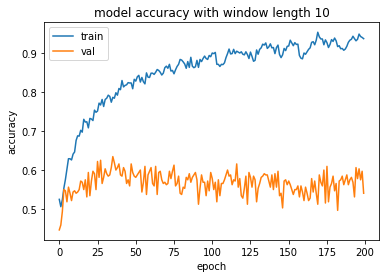

In [0]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 with transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

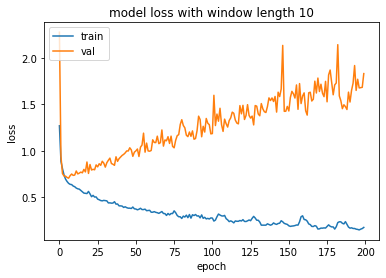

In [0]:
plt.plot(train_losses)
plt.title('model loss with window length 10 with transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
results = calc_neg_pos_rate(base_model.evaluate(x=test_generator))
print('test:', results)

160/160 [==============================] - 0s 144us/step
for window length 10 we have: test loss, test acc: [5.467251539230347, 0.40625]


In [0]:
results = calc_neg_pos_rate(base_model.evaluate(x=train_generator))
print('train:', results)